In [1]:
import theano.tensor as T
import theano
from tqdm import trange
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal, gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from  matplotlib import colors
from numpy import linalg
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [2]:
class SVGD():
    """class that will perform svgd via self.update"""
    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        """gaussian rbf kernel function"""
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt( h**2 / np.log(theta.shape[0]+1)) 
           # h = np.sqrt( h**2 ) 
        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)
        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, alpha = 0.9, debug = False):
        """performs svgd
        Args:
            x0: np array - the initial set of particles
            lnprob: function - logarithmic gradient of the target density
            n_iter: int - number of iterations to run
            stepsize: float
            alpha: float - correction factor
            debug: boolean - verbose console output
        Returns:
            theta: np array - particles after svgd
        """
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor + np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta
    
    def only_gradient(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        """performs only the gradiational descend part of svgd"""
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad)) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta
    
    def only_kernel(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        """performs only the kernel part of svgd, the repulsive force"""
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        theta = np.copy(x0) 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print ('iter ' + str(iter+1))  
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (dxkxy) / x0.shape[0]  
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
        return theta

In [3]:
class MVN:
    """a multivariate normal distribution"""
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A
        self.inv = linalg.inv(A)
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.inv)

In [5]:
var_matrix = []

for D in trange(1, 10):
    A = np.random.random((D,D)) * 2
    A = np.dot(A, A.T)

    m = np.max(A) + 0.1
    B = np.eye(D) *m
    A = A + B
    num = 40*D

    mu = np.random.random((1, D))
    model = MVN(mu, A)
    x0 = np.random.normal(0,1, [num, D])
    
    theta = SVGD().update(x0, model.dlnprob, n_iter=20000*D, stepsize=1e-2)
    #mean = np.mean(theta, axis=0)  + np.random.random(1)
    #var_theta = np.cov(theta.T) + np.random.random(1)
    #x0 = np.random.multivariate_normal(mean, var_theta,num)
    var_matrix.append(theta)
    


100%|██████████| 9/9 [28:14<00:00, 188.30s/it]


9

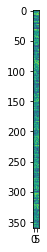

In [23]:
a = var_matrix[8]
plt.imshow(a)
np.linalg.matrix_rank(var_matrix[8])

In [18]:
2560/40

64.0